In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from livelossplot import PlotLossesKeras

#copypasted -> for gpu usage
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib 

Using TensorFlow backend.


In [2]:
# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Amount of GPUs available: 4


In [3]:
#Get data and make it usable
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()
df['gasPower'] = df['gasPower']*10 #This factor is used for getting a higher mean squared error and make it easier for working
df_d = df.resample('1D').mean() #Resampling to a day
df_d['T-1'] = df_d['T'].shift(1)
df_d = df_d.dropna()
df_d.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,gasPower,T-1
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-23,1558.435883,0.0,1805.226395,0.0,173.374907,0.0,1685.894847,239.148194,265.916667,11.608438,...,0.461319,0.149737,8.590000,8.163889,6.441597,86.511805,12887.305430,41.759722,4.857127,9.236111
2017-02-24,1561.837229,0.0,1806.231979,0.0,246.992340,0.0,1694.890589,278.093543,45.766667,5.032826,...,0.054306,2.962413,4.746250,3.968194,2.241736,83.740972,28850.902303,13.997222,2.768300,8.590000
2017-02-25,1564.963013,0.0,1808.506632,0.0,150.144606,0.0,1698.313894,202.265418,14.750000,6.502271,...,0.002083,0.361316,5.606806,4.653194,2.398264,79.870832,28918.541423,9.211111,0.171661,4.746250
2017-02-26,1564.963013,0.0,1817.410950,0.0,679.171475,0.0,1706.148254,208.350207,82.633334,7.540049,...,0.098611,0.039483,8.688750,8.264306,6.636181,86.559028,20726.805461,17.117361,5.030009,5.606806
2017-02-27,1566.147619,0.0,1828.823593,0.0,253.032893,0.0,1711.548060,192.541318,111.916667,7.891396,...,0.347222,0.208333,8.878611,8.303889,5.900139,81.353472,37413.750102,20.416667,1.315816,8.688750


In [4]:
#Add dummies!
df_d['hour'] = df_d.index.hour #create dummy variable (hour)
df_d['dayofweek'] = df_d.index.dayofweek #Create dummy variable (day of the week)
columns_to_cat = ['hour', 'dayofweek']
df_d[columns_to_cat] = df_d[columns_to_cat].astype('category') # change datetypes->category
df_d = pd.get_dummies(df_d, columns=columns_to_cat)


In [5]:
#Split, originally thought about using the train_test_split function but it seems to give some errors
X = df_d[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]
y = df_d[['gasPower']]
#labelencoder_y_1 = LabelEncoder()
#y = labelencoder_y_1.fit_transform(y)
y = np.array(y)

train_size=0.6
split_index = int(df_d.shape[0]*train_size)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

#scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train) #Normalization! :D


In [6]:
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

print((X_train.shape, y_train.shape))

print((X_test.shape, y_test.shape))

((165, 9), (165, 1))
((110, 9), (110, 1))


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
model = Sequential()

#first layer with the input data
model.add(Dense(output_dim =16, init = 'uniform', activation = 'relu', input_dim = 9))
#second layer 
model.add(Dense(output_dim = 128, init = 'uniform', activation = 'relu'))
#output layer
model.add(Dense(output_dim = 1))

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=16, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128, kernel_initializer="uniform")`
  
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [8]:
model = multi_gpu_model(model, gpus=num_gpu)

In [9]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mape'])

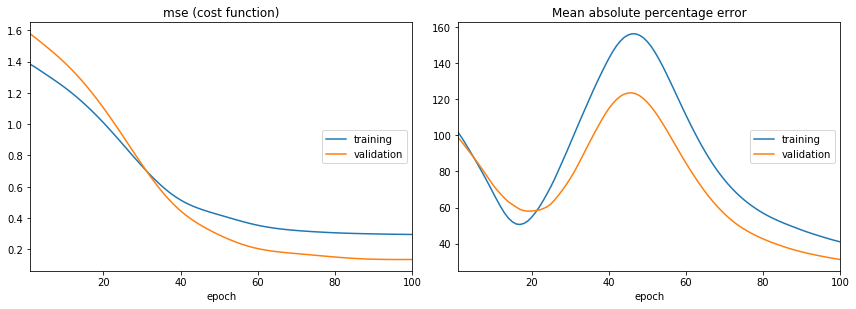

165/165 [==============================] - 0s - loss: 0.2958 - mean_absolute_percentage_error: 40.9448 - val_loss: 0.1361 - val_mean_absolute_percentage_error: 31.1365


In [10]:
#y_train = (y_train-min(y_train))/(max(y_train)-min(y_train))
#y_test = (y_test-min(y_test))/(max(y_test)-min(y_test))

model.fit(X_train, y_train, batch_size =int(len(X_train)),epochs = 100,verbose=1,validation_data=(X_test, y_test),callbacks=[PlotLossesKeras()])

In [11]:
y_predict = model.predict(X_test)
x_datetime = df_d.index[len(X_train):]
#y_test = (y_test-min(y_test))/(max(y_test)-min(y_test))
#y_predict = scalery.inverse_transform(y_predict)

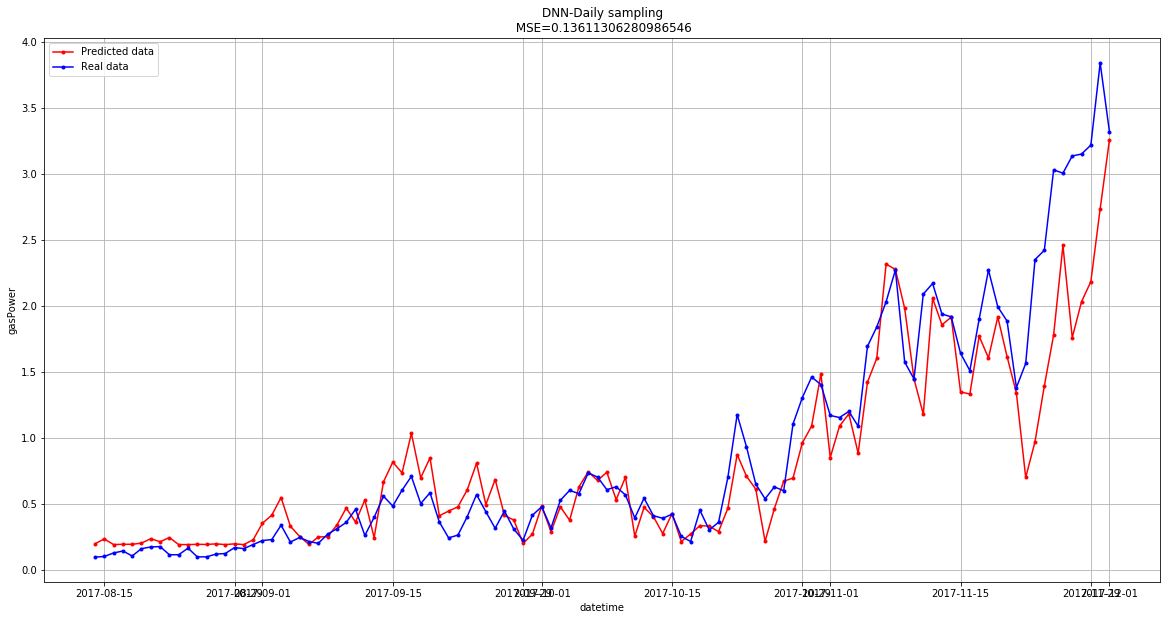

In [12]:
plt.figure(figsize=(20,10))

#This will plot the prediction 
plt.title('DNN-Daily sampling\n MSE='+str(mean_squared_error(y_test,y_predict)))
plt.plot(x_datetime,y_predict,'.-',color='r',label='Predicted data')
plt.xlabel('datetime')
plt.ylabel('gasPower')
plt.grid(True)

#This will plot the real data
plt.plot(x_datetime,y_test,'.-',color='b',label='Real data')
plt.xlabel('datetime')
plt.ylabel('gasPower')
plt.legend()
plt.show()